    Problem Statement:

    The categorization of images into distinct classes is a pervasive task in computer vision, and it has a wide array of applications, including in pet identification and animal monitoring systems. In this assignment, we aim to develop a model capable of accurately distinguishing between cat and dog images. Instead of building a convolutional neural network (CNN) from scratch, we will leverage transfer learning using the VGG16 model, a pre-trained model on the ImageNet dataset. VGG16 is renowned for its effectiveness in image recognition tasks, but it does not have broad categories for cats and dogs. Therefore, we will utilize the convolutional (Conv) layers of VGG16 for feature extraction and add custom fully connected (Cat) layers for the classification task.

    Background
VGG16 is a pre-trained model. It is a convolutional neural network architecture that was originally proposed by the Visual Geometry Group (VGG) from the University of Oxford. It achieved high performance on the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2014.

Pre-trained models like VGG16 are trained on large datasets (e.g., ImageNet) and can be used for various tasks such as image classification, object detection, or feature extraction in transfer learnin

Import Libraries

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Dropout,RandomFlip,RandomRotation,RandomZoom,RandomTranslation
from tensorflow.keras.regularizers import L2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory, get_file

    Objectives:

Utilize VGG16 for Feature Extraction:

● Employ the VGG16 model, excluding its top layers, to serve as a feature extractor for cat and dog images.

● Ensure the input images are of the correct size (150x150) and preprocessed appropriately to match VGG16’s requirements.

In [2]:
#Initialized with weights pre-trained on the ImageNet dataset
#include_top=False: This argument indicates that the top layers of the VGG16 model, which are fully connected layers responsible for classification, should not be included. 
#By excluding these layers, we are essentially extracting the learned features from the convolutional base of the network.

BATCH_SIZE = 128
IMG_SIZE = (150, 150)
IMG_SHAPE = IMG_SIZE + (3,)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Data Preprocessing and Augmentation:

Implement image data generators for real-time data augmentation, ensuring a robust and varied dataset for training the classification layers.

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')

train_dataset = image_dataset_from_directory(train_dir,image_size=IMG_SIZE,batch_size=BATCH_SIZE,shuffle=True)
validation_dataset = image_dataset_from_directory(val_dir,image_size=IMG_SIZE,batch_size=BATCH_SIZE,shuffle=True)

# class_names = train_dataset.class_names
# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

#As the original dataset doesn't contain a test set, you will create one. 
#To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

#Use buffered prefetching to load images from disk without having I/O become blocking.
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. 
#This helps expose the model to different aspects of the training data and reduce overfitting.
#These layers are active only during training, when you call Model.fit. 
#They are inactive when the model is used in inference mode in Model.evaluate, Model.predict, or Model.call
data_augmentation = Sequential([
    RandomFlip('horizontal'),               # Flip horizontally
    RandomRotation(0.2),                    # Rotate images by 20% of 360 degrees (72 degrees)
    RandomTranslation(0.2, 0.2),            # Shift images by 20% of width and height
    #RandomShear(0.2),                       # Shear images with a factor of 0.2
    RandomZoom(0.2),                        # Zoom images in or out by 20%
])

#Let's repeatedly apply these layers to the same image and see the result
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Number of validation batches: 7
Number of test batches: 1


In [4]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Build and Train the Classification Model:

● Add custom fully connected layers on top of the VGG16 model for the classification task.

● Freeze the convolutional layers of VGG16 to retain the pre-trained features and only train the added classification layers.

In [5]:
#Freeze the base model's layers to retain the pre-trained features
#Ensures the weights of the VGG16 layers are not updated during training. This retains the pre-trained features.
base_model.trainable = False

#Freeze the base model
#for layer in base_model.layers:
#    layer.trainable=False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:

# Add custom fully connected layers  on top of the VGG16 model for the classification task.
model=Sequential()
model.add(base_model)
model.add(data_augmentation)
model.add(layers.Flatten())
model.add(Dropout(0.3))
model.add(layers.Dense(256,activation='relu',kernel_regularizer=L2(0.01)))
model.add(Dropout(0.3))
model.add(layers.Dense(64,activation='relu',kernel_regularizer=L2(0.01)))
model.add(Dropout(0.3))
model.add(layers.Dense(2,activation='softmax'))

# Model summary
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model Compilation and Training:

● Compile the model using stochastic gradient descent, categorical cross-entropy as the loss function, and accuracy as the evaluation metric.

In [7]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),loss='sparse_categorical_crossentropy', metrics=['accuracy'])


● Train the model using the training data, and validate its performance using a validation set.

In [8]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

lr_callback = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)



7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 853ms/step - accuracy: 0.4728 - loss: 16.2068
initial loss: 15.27
initial accuracy: 0.50
Epoch 1/100
 16/100 ━━━━━━━━━━━━━━━━━━━━ 30s 361ms/step - accuracy: 0.7460 - loss: 10.7227

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.8052 - loss: 9.0943 - val_accuracy: 0.9060 - val_loss: 6.5026 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8779 - loss: 6.8555 - val_accuracy: 0.9404 - val_loss: 6.1976 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9034 - loss: 6.3263 - val_accuracy: 0.9369 - val_loss: 6.1295 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9162 - loss: 6.1966 - val_accuracy: 0.9369 - val_loss: 6.0917 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9182 - loss: 6.1319 - val_accuracy: 0.9404 - val_loss: 6.0502 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9312 - loss: 6.0854 - val_accuracy: 0.9427 - val_loss: 6.0094 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9264 - loss: 6.0302 

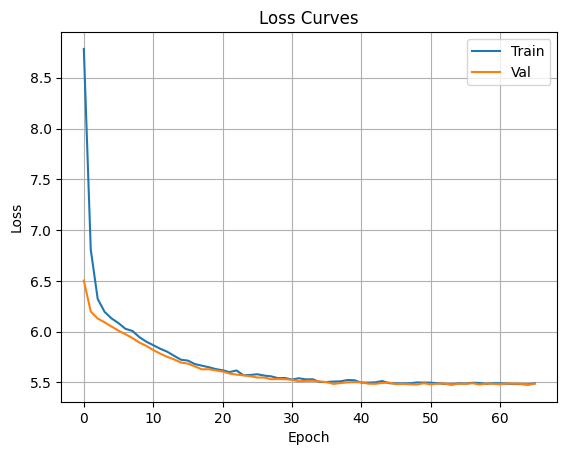

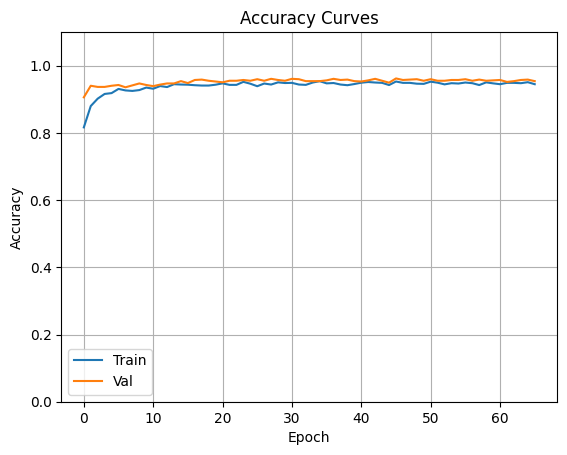

In [9]:
# Initial loss and accuracy
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

# Train the model
model.fit(train_dataset,epochs=100,validation_data=validation_dataset,steps_per_epoch=100,validation_steps=50,callbacks=[lr_callback,early_stopping])

#Track accuracy
train_loss = model.history.history["loss"]
val_loss = model.history.history["val_loss"]

train_acc = model.history.history["accuracy"]
val_acc = model.history.history["val_accuracy"]

plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend(["Train", "Val"])
plt.grid()
plt.show()

plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1.1)
plt.title("Accuracy Curves")
plt.legend(["Train", "Val"])
plt.grid()
plt.show()

Evaluate and Test the Model:

● Assess the model’s performance based on its accuracy in classifying images into cat or dog categories.

● Implement a prediction function to classify new images, providing the predicted category and the associated confidence level.

In [14]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9453 - loss: 5.5312
Test Accuracy: 0.9453
Test Loss: 5.5312


In [35]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Define class names
class_names = ['Cat', 'Dog']  # Modify as needed for your dataset

def predict_image(model, img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(150, 150))  # Adjust size for your model
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values (if necessary)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the class index
    confidence = np.max(predictions)  # Get the confidence score

    # Output results
    print(f"Predicted Category: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.2f}")
    return class_names[predicted_class], confidence

# Example usage:

image_path = "/kaggle/input/cats-dogs/247.jpg"
predict_image(model, image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Category: Cat
Confidence: 0.51


('Cat', 0.5133049)